# Multiple Regression (gradient descent)

We will use graphlab along with numpy to solve for the regression weights with gradient descent.

In this notebook we will cover estimating multiple regression weights via gradient descent. You will:
* Add a constant column of 1's to a graphlab SFrame to account for the intercept
* Convert an SFrame into a Numpy array
* Write a predict_output() function using Numpy
* Write a numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size and tolerance.
* Use the gradient descent function to estimate regression weights for multiple features

# Fire up graphlab create

Make sure you have the latest version of graphlab (>= 1.7)

In [1]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = graphlab.SFrame('kc_house_data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to arslanahmadid@gmail.com and will expire on October 28, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.0.1 started. Logging: C:\Users\arslan\AppData\Local\Temp\graphlab_server_1552739060.log.0


If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the other Week 2 notebook. For this notebook, however, we will work with the existing features.

# Convert to Numpy Array

Although SFrames offer a number of benefits to users (especially when using Big Data and built-in graphlab functions) in order to understand the details of the implementation of algorithms it's important to work with a library that allows for direct (and optimized) matrix operations. Numpy is a Python solution to work with matrices (or any multi-dimensional "array").

Recall that the predicted value given the weights and the features is just the dot product between the feature and weight vector. Similarly, if we put all of the features row-by-row in a matrix then the predicted value for *all* the observations can be computed by right multiplying the "feature matrix" by the "weight vector". 

First we need to take the SFrame of our data and convert it into a 2D numpy array (also called a matrix). To do this we use graphlab's built in .to_dataframe() which converts the SFrame into a Pandas (another python library) dataframe. We can then use Panda's .as_matrix() to convert the dataframe into a numpy matrix.

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead 

Now we will write a function that will accept an SFrame, a list of feature names (e.g. ['sqft_living', 'bedrooms']) and an target feature e.g. ('price') and will return two things:
* A numpy matrix whose columns are the desired features plus a constant column (this is how we create an 'intercept')
* A numpy array containing the values of the output

With this in mind, complete the following function (where there's an empty line you should write a line of code that does what the comment above indicates)

**Please note you will need GraphLab Create version at least 1.7.1 in order for .to_numpy() to work!**

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    
    features_sframe = data_sframe[features]

    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    
    output_sarray = data_sframe[output]

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

For testing let's use the 'sqft_living' feature and a constant as our features and price as our output:

In [5]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') # the [] around 'sqft_living' makes it a list
print example_features[0,:] # this accesses the first row of the data the ':' indicates 'all columns'
print example_output[0] # and the corresponding output

[1.00e+00 1.18e+03]
221900.0


# Predicting output given regression weights

Suppose we had the weights [1.0, 1.0] and the features [1.0, 1180.0] and we wanted to compute the predicted output 1.0\*1.0 + 1.0\*1180.0 = 1181.0 this is the dot product between these two arrays. If they're numpy arrayws we can use np.dot() to compute this:

In [6]:
my_weights = np.array([1., 1.]) # the example weights
my_features = example_features[0,] # we'll use the first data point
predicted_value = np.dot(my_features, my_weights)
print predicted_value

1181.0


np.dot() also works when dealing with a matrix and a vector. Recall that the predictions from all the observations is just the RIGHT (as in weights on the right) dot product between the features *matrix* and the weights *vector*. With this in mind finish the following predict_output function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [7]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

If you want to test your code run the following cell:

In [8]:
test_predictions = predict_output(example_features, my_weights)
print test_predictions[0] # should be 1181.0
print test_predictions[1] # should be 2571.0

1181.0
2571.0


# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output.

Since the derivative of a sum is the sum of the derivatives we can compute the derivative for a single data point and then sum over data points. We can write the squared difference between the observed output and predicted output for a single point as follows:

(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)^2

Where we have k features and a constant. So the derivative with respect to weight w[i] by the chain rule is:

2\*(w[0]\*[CONSTANT] + w[1]\*[feature_1] + ... + w[i] \*[feature_i] + ... +  w[k]\*[feature_k] - output)\* [feature_i]

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

2\*error\*[feature_i]

That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. In the case of the constant then this is just twice the sum of the errors!

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors. 

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).

In [9]:
def feature_derivative(errors, feature):
    # Assume that errors and feature are both numpy arrays of the same length (number of data points)
    # compute twice the dot product of these vectors as 'derivative' and return the value
    
    derivative = 2 * np.dot(errors,feature)

    return(derivative)

To test your feature derivartive run the following:

In [10]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([0., 0.]) # this makes all the predictions 0
test_predictions = predict_output(example_features, my_weights) 
# just like SFrames 2 numpy arrays can be elementwise subtracted with '-': 
errors = test_predictions - example_output # prediction errors in this case is just the -example_output
feature = example_features[:,0] # let's compute the derivative with respect to 'constant', the ":" indicates "all rows"
derivative = feature_derivative(errors, feature)
print derivative
print -np.sum(example_output)*2 # should be the same as derivative

-23345850022.0
-23345850022.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude (length) of the gradient vector to be smaller than a fixed 'tolerance'.

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent we update the weight for each feature befofe computing our stopping criteria

In [11]:
from math import sqrt # recall that the magnitude/length of a vector [g[0], g[1], g[2]] is sqrt(g[0]^2 + g[1]^2 + g[2]^2)
import matplotlib.pyplot as plt
%matplotlib inline


In [38]:
def regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance,data_sframe):
    temp_predictions = [] 
    temp_weights = []
    converged = False 
    weights = np.array(initial_weights) # make sure it's a numpy array
    while not converged:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        
        predictions = predict_output(feature_matrix,weights)
        
        temp_predictions.append(predictions)
        temp_weights.append(weights)
        
        # compute the errors as predictions - output
        
        errors = predictions - output

        gradient_sum_squares = 0 # initialize the gradient sum of squares
        # while we haven't reached the tolerance yet, update each feature's weight
        for i in range(len(weights)): # loop over each weight
            # Recall that feature_matrix[:, i] is the feature column associated with weights[i]
            # compute the derivative for weight[i]:
            
            derivative = feature_derivative(errors, feature_matrix[:,i])

            # add the squared value of the derivative to the gradient sum of squares (for assessing convergence)
            
            gradient_sum_squares = gradient_sum_squares + derivative**2

            # subtract the step size times the derivative from the current weight
            
            weights[i] = weights[i] - step_size*(derivative)
            
        # compute the square-root of the gradient sum of squares to get the gradient magnitude:
        gradient_magnitude = sqrt(gradient_sum_squares)
        if gradient_magnitude < tolerance:
            converged = True
    return(temp_predictions,temp_weights,weights)

A few things to note before we run the gradient descent. Since the gradient is a sum over all the data points and involves a product of an error and a feature the gradient itself will be very large since the features are large (squarefeet) and the output is large (prices). So while you might expect "tolerance" to be small, small is only relative to the size of the features. 

For similar reasons the step size will be much smaller than you might expect but this is because the gradient has such large values.

# Running the Gradient Descent as Simple Regression

First let's split the data into training and test data.

In [39]:
train_data,test_data = sales.random_split(.8,seed=0)

Although the gradient descent is designed for multiple regression since the constant is now a feature we can use the gradient descent function to estimat the parameters in the simple regression on squarefeet. The folowing cell sets up the feature_matrix, output, initial weights and step size for the first model:

In [40]:
# let's test out the gradient descent
simple_features = ['sqft_living']
my_output = 'price'
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
initial_weights = np.array([-47000., 1.])
step_size = 7e-12
tolerance = 2.5e7

Next run your gradient descent with the above parameters.

In [41]:
temp_predictions,temp_weights,weights = regression_gradient_descent(simple_feature_matrix, output, initial_weights, step_size, tolerance,train_data)
weights

array([-46999.88716555,    281.91211912])

Learned weights after 0 step of gradient descent algorithm
Learned weights after 1 step of gradient descent algorithm
Learned weights after 2 step of gradient descent algorithm
Learned weights after 3 step of gradient descent algorithm
Learned weights after 4 step of gradient descent algorithm
Learned weights after 5 step of gradient descent algorithm
Learned weights after 6 step of gradient descent algorithm
Learned weights after 7 step of gradient descent algorithm
Learned weights after 8 step of gradient descent algorithm
Learned weights after 9 step of gradient descent algorithm
Learned weights after 10 step of gradient descent algorithm
Learned weights after 11 step of gradient descent algorithm


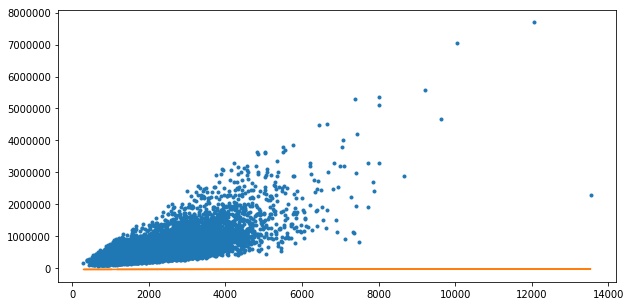

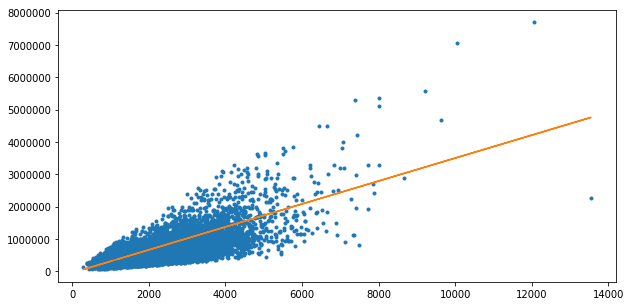

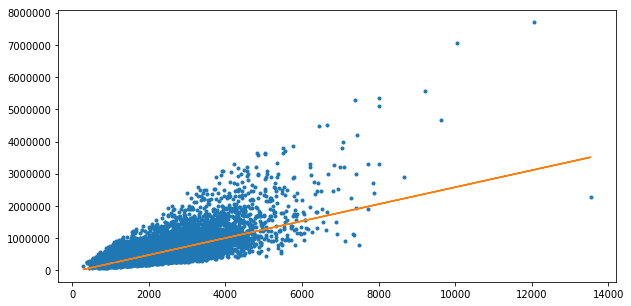

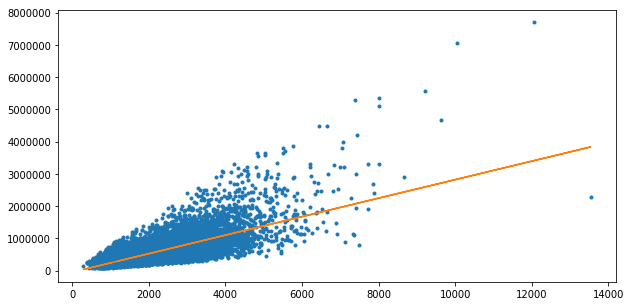

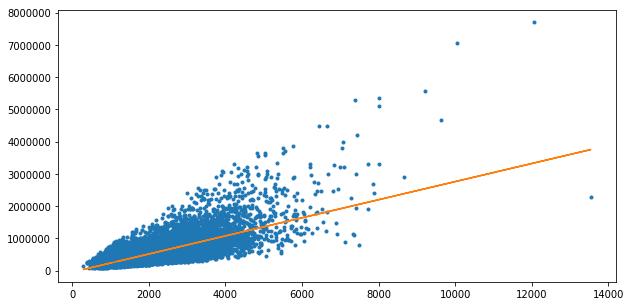

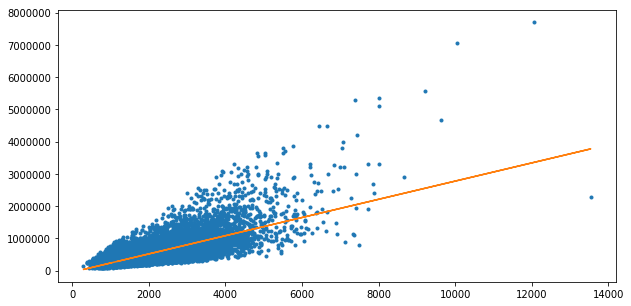

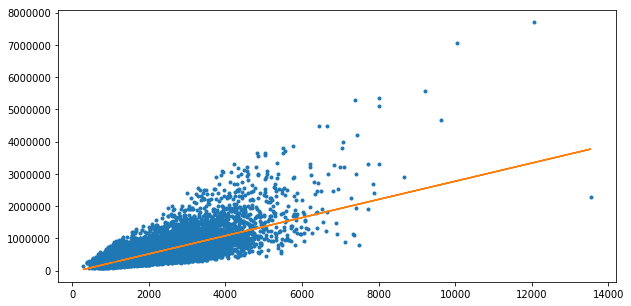

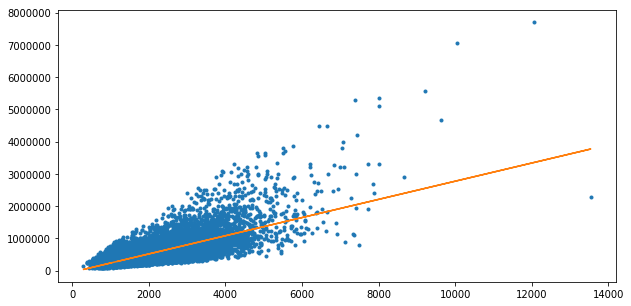

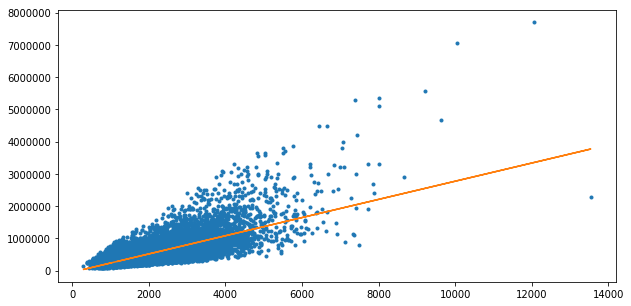

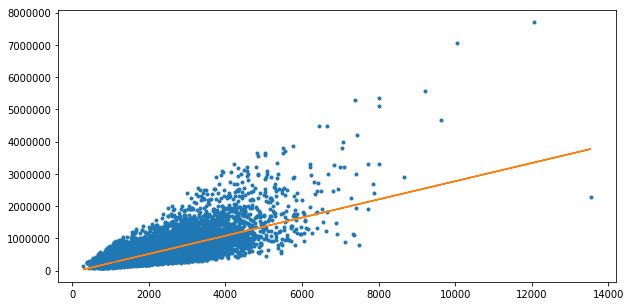

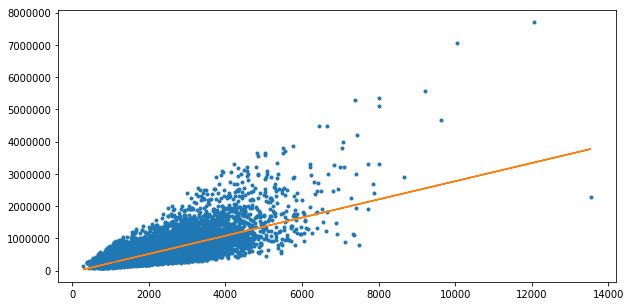

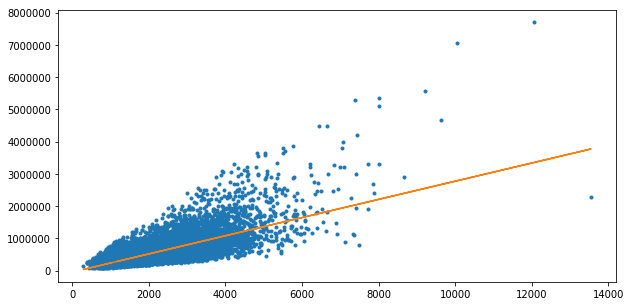

In [42]:
# Basically this below code plot the graph on the learned weights from gradient descent algorithm on eaach step

import matplotlib.pyplot as plt
%matplotlib inline
for i,prediction in enumerate(temp_predictions):
    plt.figure(figsize=(10,5))
    print 'Learned weights after ' + str(i) + ' step of gradient descent algorithm'
    plt.plot(train_data['sqft_living'],train_data['price'],'.',
             train_data['sqft_living'], prediction,'-')

How do your weights compare to those achieved in week 1 (don't expect them to be exactly the same)? 

**Quiz Question: What is the value of the weight for sqft_living -- the second element of ‘simple_weights’ (rounded to 1 decimal place)?**

Use your newly estimated weights and your predict_output() function to compute the predictions on all the TEST data (you will need to create a numpy array of the test feature_matrix and test output first:

In [43]:
(test_simple_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Now compute your predictions using test_simple_feature_matrix and your weights from above.

In [44]:
test_predictions = predict_output(test_simple_feature_matrix,weights)

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 1 (round to nearest dollar)?**

In [45]:
test_predictions[0]

356134.4431709297

In [46]:
test_output[0]

310000.0

Now that you have the predictions on test data, compute the RSS on the test data set. Save this value for comparison later. Recall that RSS is the sum of the squared errors (difference between prediction and output).

In [47]:
RSS = ((test_output - test_predictions)**2).sum()
RSS

275400047593155.94

# Running a multiple regression

Now we will use more than one actual feature. Use the following code to produce the weights for a second model with the following parameters:

In [48]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
initial_weights = np.array([-100000., 1., 1.])
step_size = 4e-12
tolerance = 1e9

Use the above parameters to estimate the model weights. Record these values for your quiz.

In [49]:
multiple_weights = regression_gradient_descent(feature_matrix, output, initial_weights, step_size, tolerance, train_data)
multiple_weights

([array([-97480., -95740., -96510., ..., -96940., -96990., -97960.]),
  array([421002.96577892, 792804.3785608 , 603427.43848423, ...,
         534683.2867589 , 526304.56305387, 323122.22062344]),
  array([259518.53331584, 519010.81199792, 380998.2189088 , ...,
         338458.60344862, 333152.72488025, 192305.75558163]),
  array([308947.89676147, 605683.9180731 , 444775.73350445, ...,
         399005.83731368, 393224.89063921, 232670.58074683]),
  array([292976.07471613, 580513.52215816, 419907.35778441, ...,
         379920.45263373, 374753.51300031, 219946.9898073 ]),
  array([297304.20852359, 589991.74762577, 422653.98204139, ...,
         385541.08518485, 380639.29427419, 223694.07819052]),
  array([295350.9780301 , 588683.74349714, 416953.40939044, ...,
         383506.02116493, 378966.77101404, 222337.36850529]),
  array([295360.46021516, 590682.46752576, 413987.85011566, ...,
         383852.36122424, 379634.89188271, 222568.26165735]),
  array([294775.3385645 , 591617.78404005

Use your newly estimated weights and the predict_output function to compute the predictions on the TEST data. Don't forget to create a numpy array for these features from the test set first!

In [74]:
(test_model_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

**Quiz Question: What is the predicted price for the 1st house in the TEST data set for model 2 (round to nearest dollar)?**

In [75]:
test_predictions = predict_output(test_model_feature_matrix,multiple_weights)
test_predictions[0]

366651.4120365591

What is the actual price for the 1st house in the test data set?

In [76]:
test_output[0]

310000.0

**Quiz Question: Which estimate was closer to the true price for the 1st house on the TEST data set, model 1 or model 2?**

In [ ]:
# model 1 has closer to the true price

Now use your predictions and the output to compute the RSS for model 2 on TEST data.

In [77]:
RSS = ((test_output - test_predictions)**2).sum()
RSS

270263446465244.06

**Quiz Question: Which model (1 or 2) has lowest RSS on all of the TEST data? **

In [ ]:
# model 2 has low RSS